In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography


In [3]:
import json

with open('colors.json', 'r') as f:
    color_dict = json.load(f)

In [4]:
# adata_control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
# adata_ko = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
# adata_ko2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')

adata_control = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_lymph1_visiumHD.h5ad')
adata_ko = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_lymphKO4_visiumHD.h5ad')
adata_ko2 = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_lymphKO2_visiumHD.h5ad')


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ko_counts = adata_ko.obs.cell_type.value_counts()
control_counts = adata_control.obs.cell_type.value_counts()
ko2_counts = adata_ko2.obs.cell_type.value_counts()

ko_props = ko_counts / ko_counts.sum()
control_props = control_counts / control_counts.sum()
ko2_props = ko2_counts / ko2_counts.sum()

# Get unique cell types for consistent coloring (union of all cell types)
all_cell_types = sorted(
    set(ko_props.index)
    | set(control_props.index)
    | set(ko2_props.index)
)

In [15]:
def get_pie_args(props):
    labels = []
    values = []
    pie_colors = []
    for ct in all_cell_types:
        if ct in props.index:
            labels.append(ct)
            values.append(props[ct])
            pie_colors.append(color_dict[ct])
    return values, labels, pie_colors

def plot_celltype_pie(props, title, filename):
    values, labels, pie_colors = get_pie_args(props)
    fig, ax = plt.subplots(figsize=(10,10), dpi=200)
    wedges, texts, autotexts = ax.pie(
        values, 
        colors=pie_colors, 
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        pctdistance=0.8,
        textprops={'fontsize': 50}
    )

    for i, autotext in enumerate(autotexts):
        if autotext.get_text() != '':
            # Get the angle of the wedge's center
            ang = (wedges[i].theta2 + wedges[i].theta1) / 2.
            x = np.cos(np.deg2rad(ang))
            y = np.sin(np.deg2rad(ang))
            # Jitter: move label slightly outward and a bit tangentially
            # jitter = 0.05
            jitter = 0.0
            autotext.set_position((1.05 * x + jitter * (-y), 1.05 * y + jitter * x))
            autotext.set_fontsize(5)
            autotext.set_weight('bold')

    ax.legend(
        labels,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=10,
        frameon=False,
        title='Cell Type'
    )

    ax.set_title(title, fontsize=15, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f"figures/{filename}.svg", bbox_inches='tight', transparent=True, format='svg', dpi=300)

    return fig, ax


(<Figure size 2000x2000 with 1 Axes>,
 <Axes: title={'center': 'Knockout2 Celltype Proportions'}>)

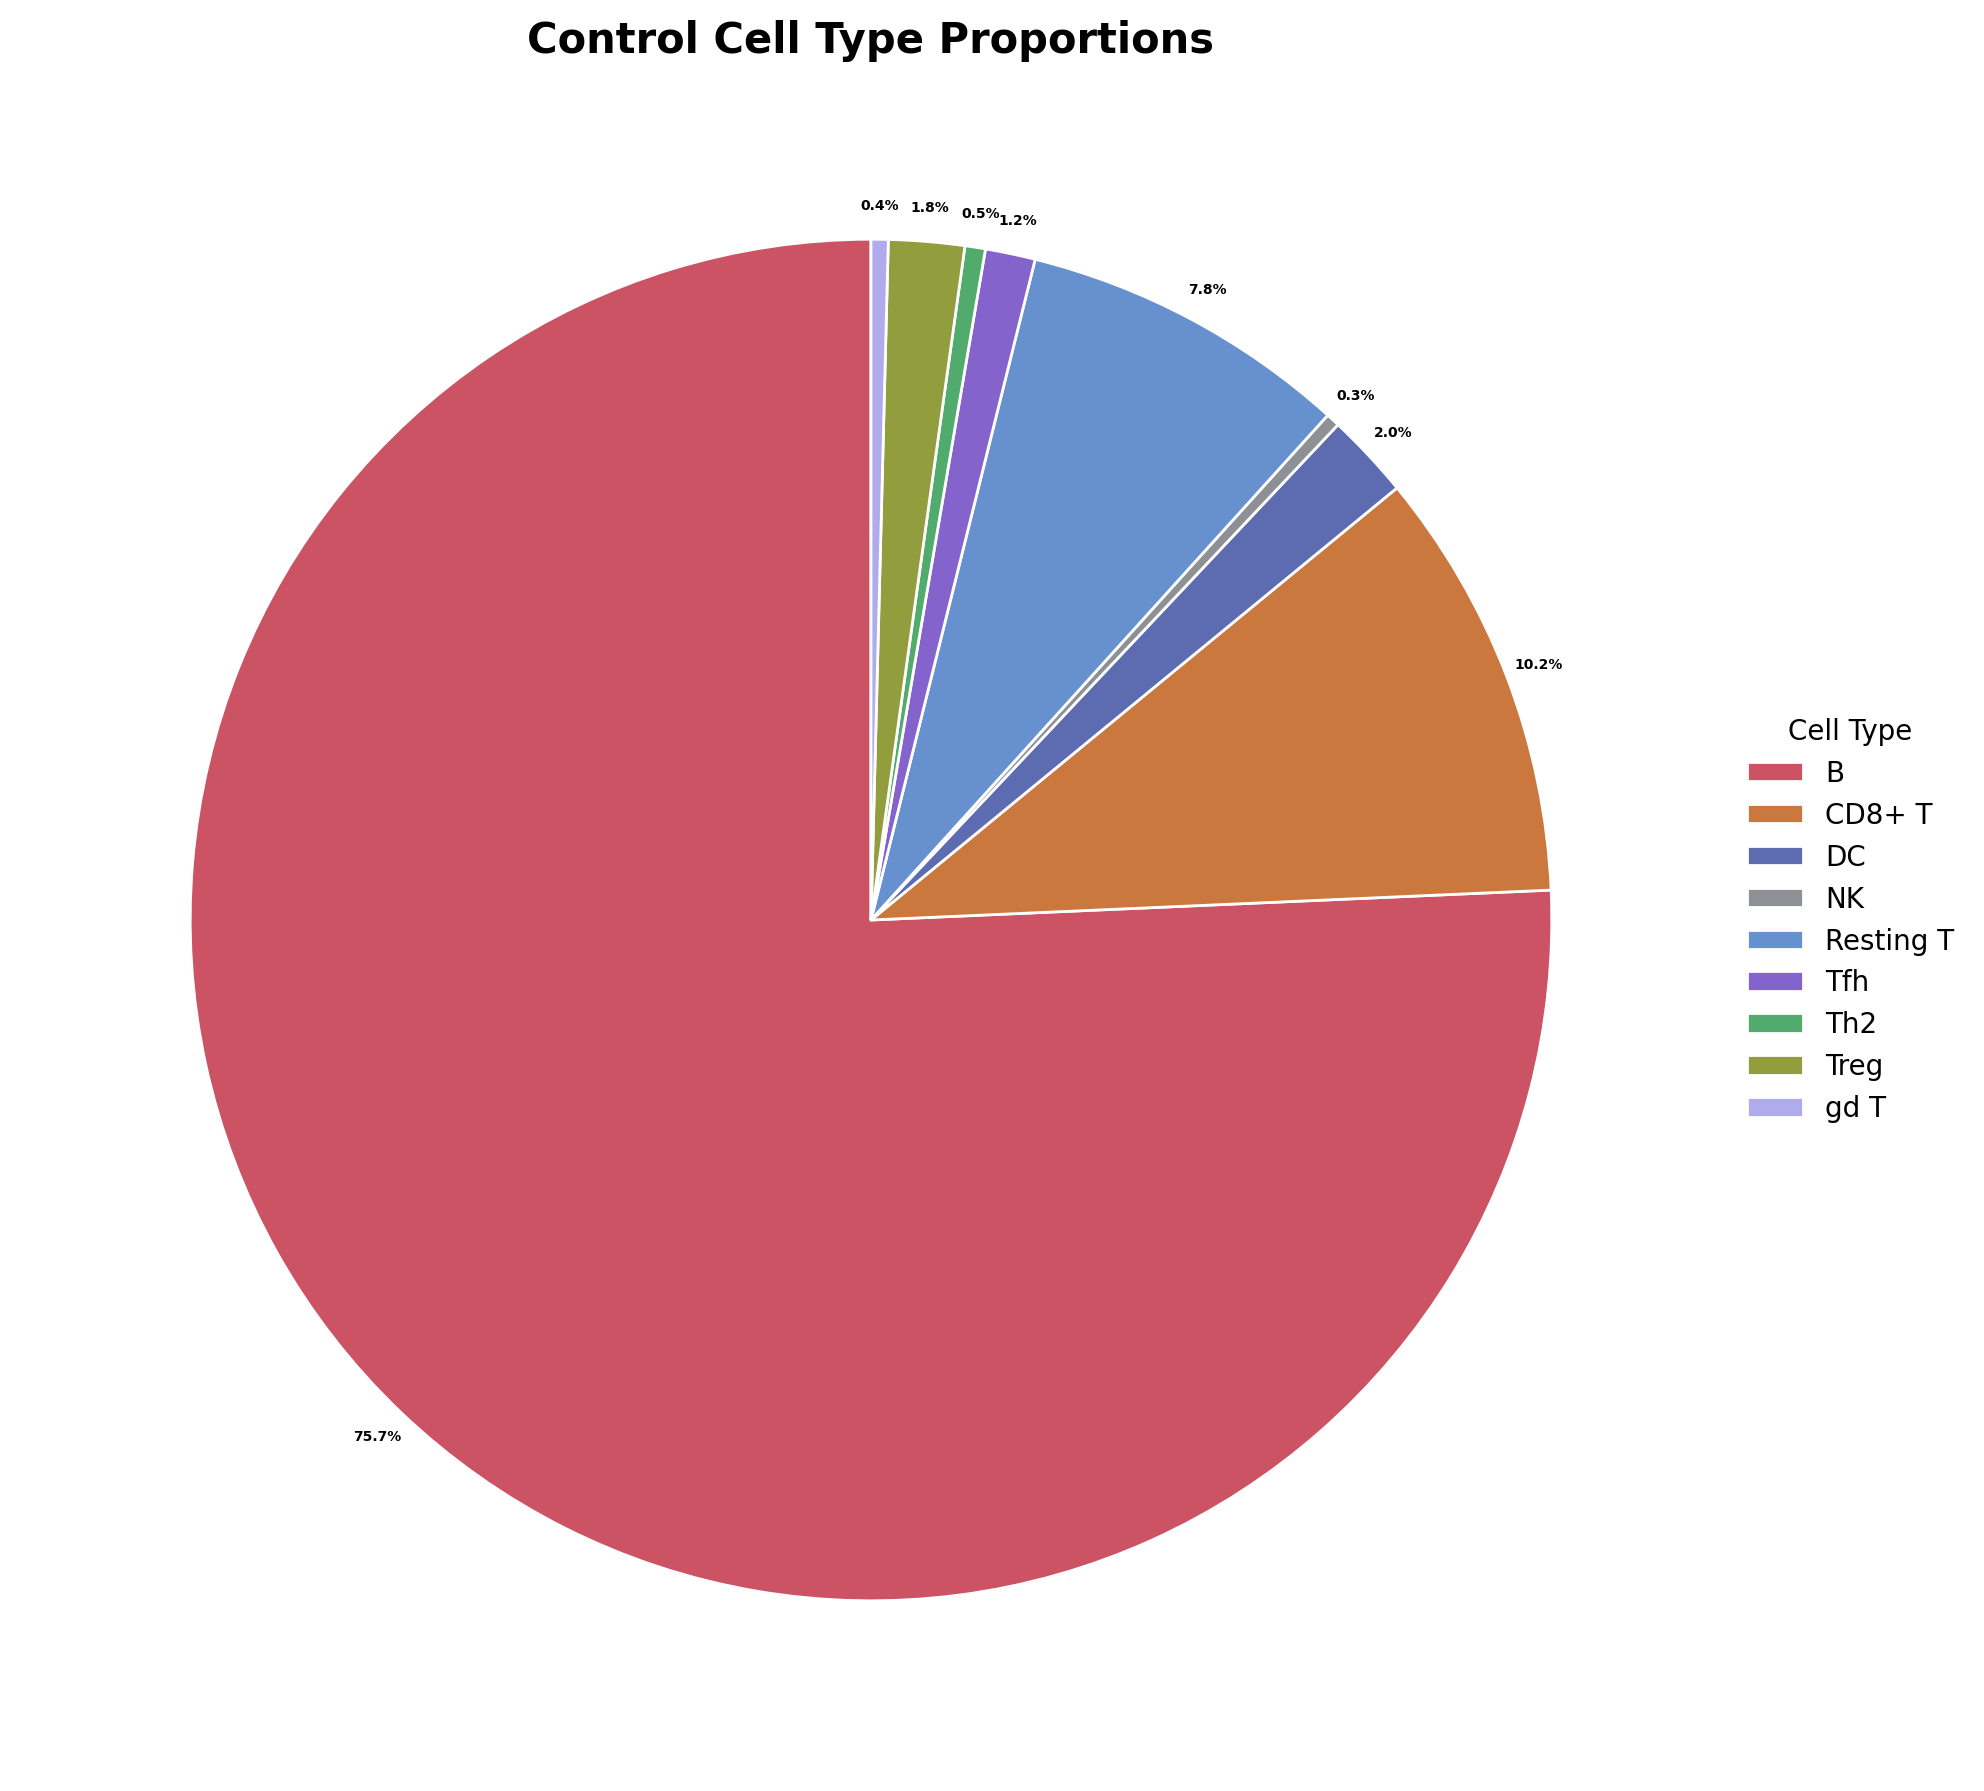

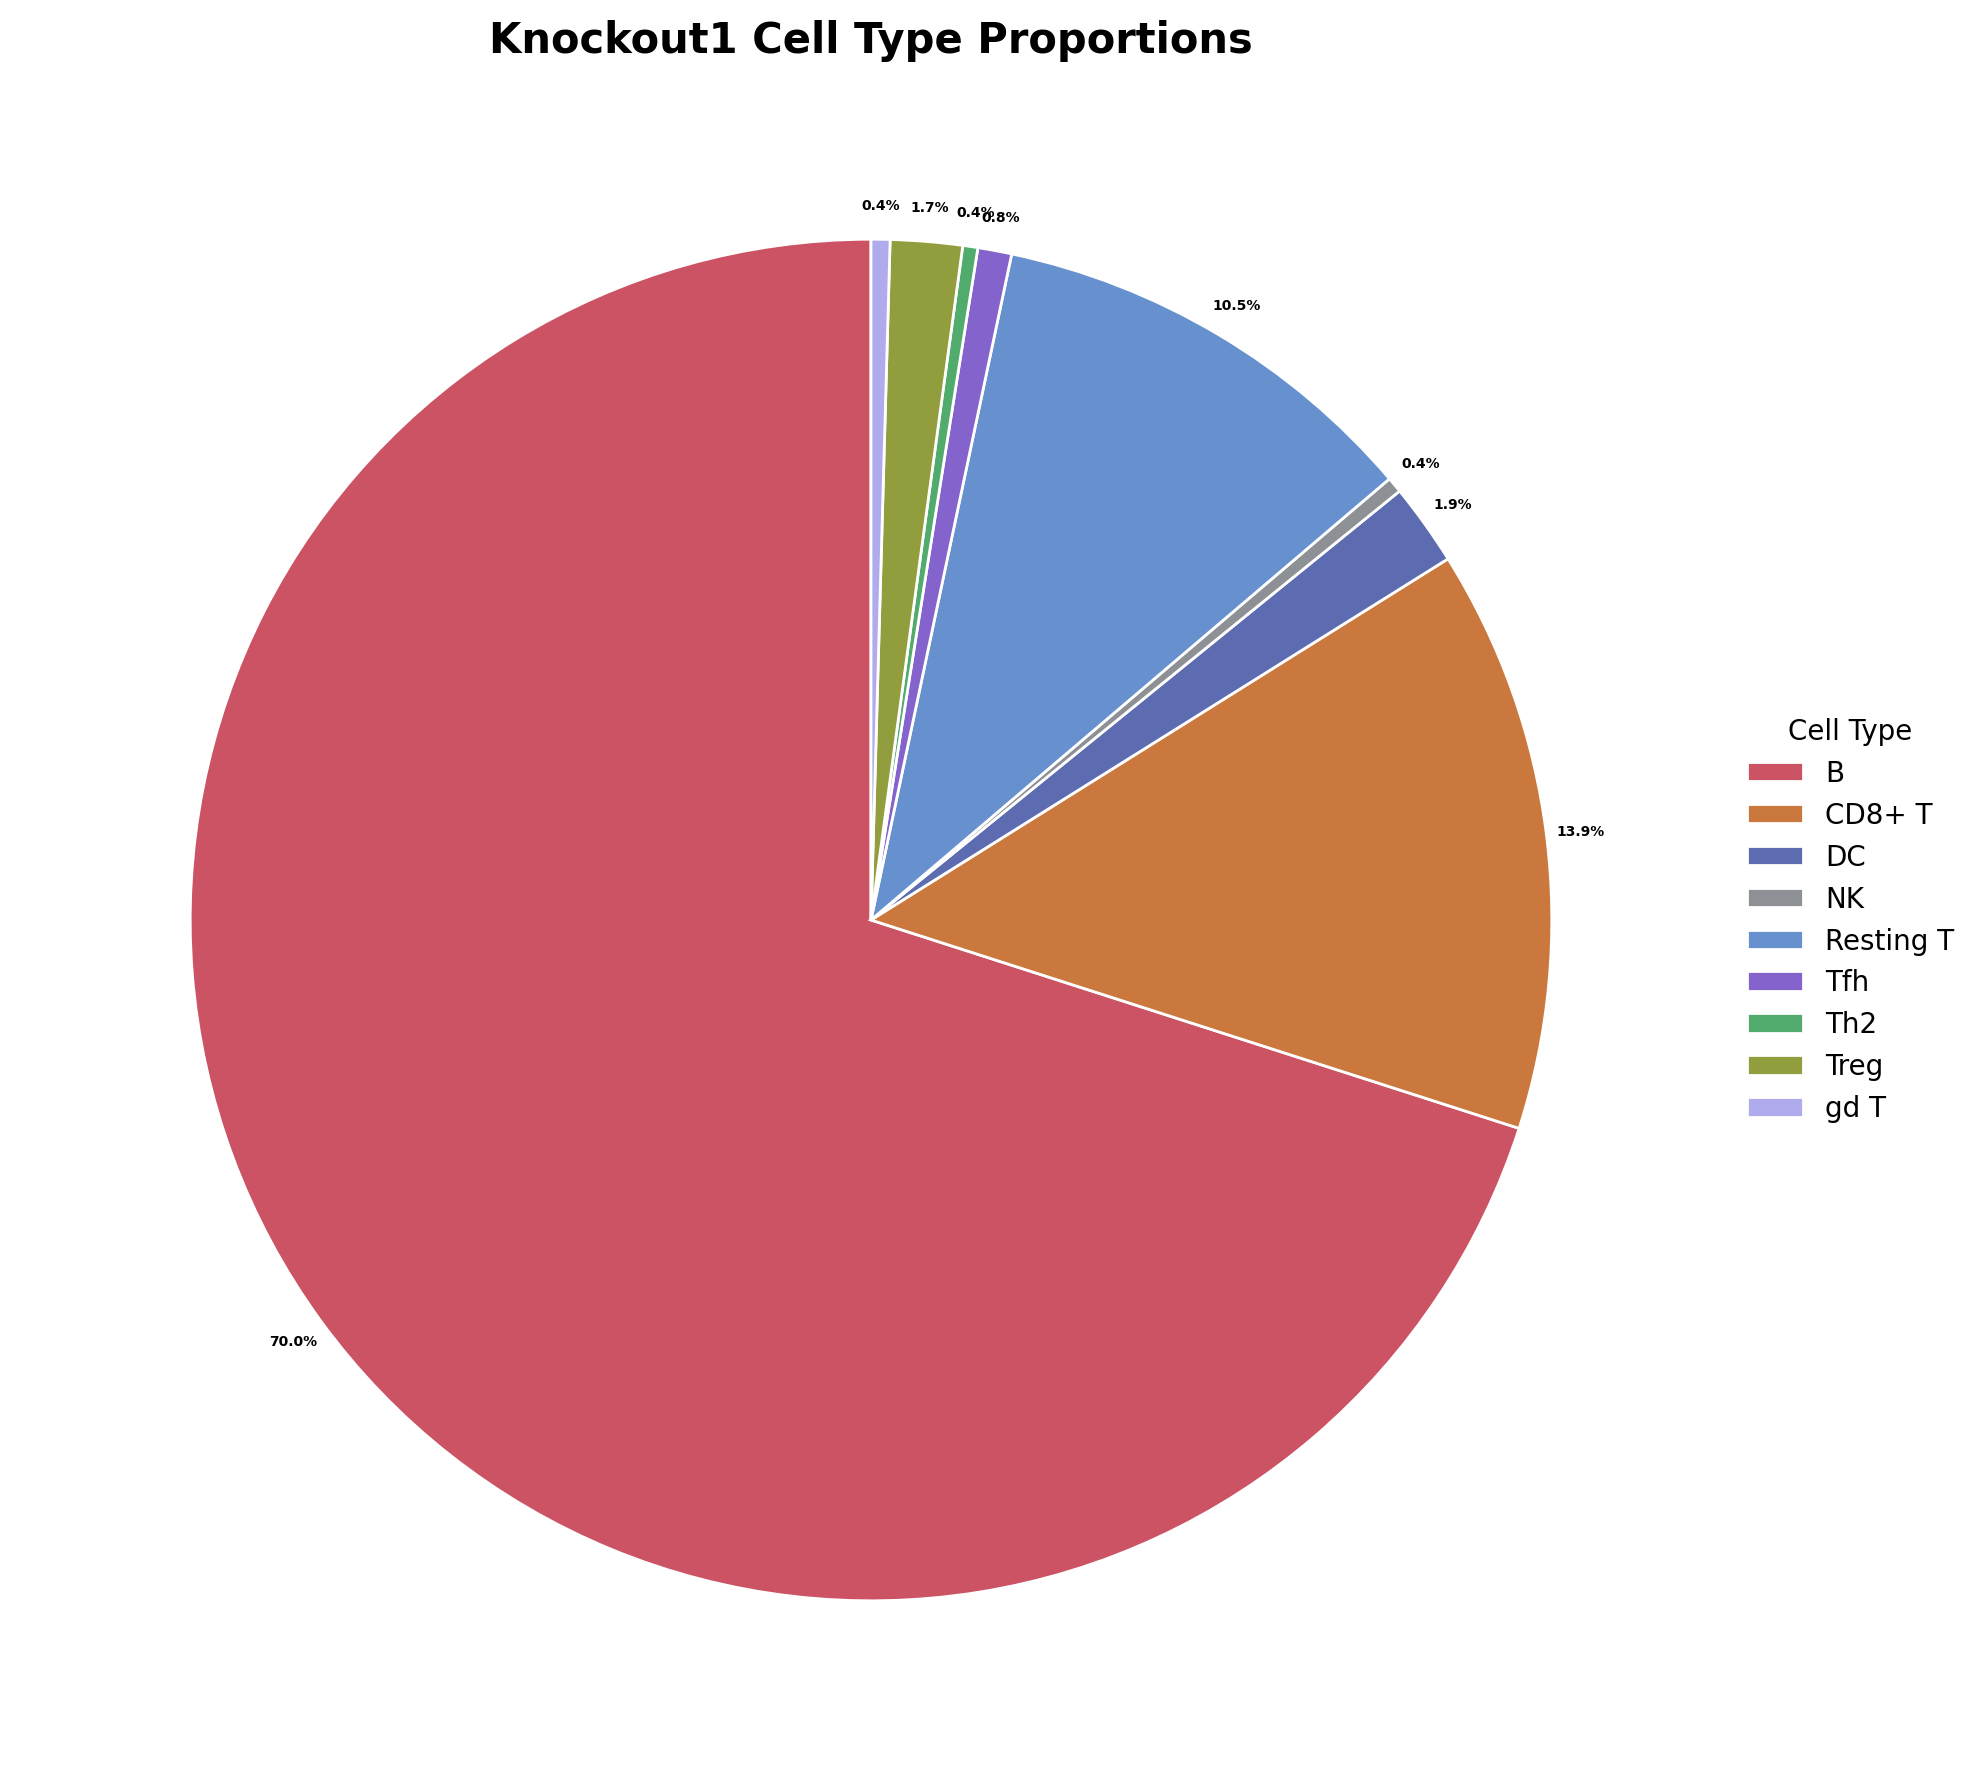

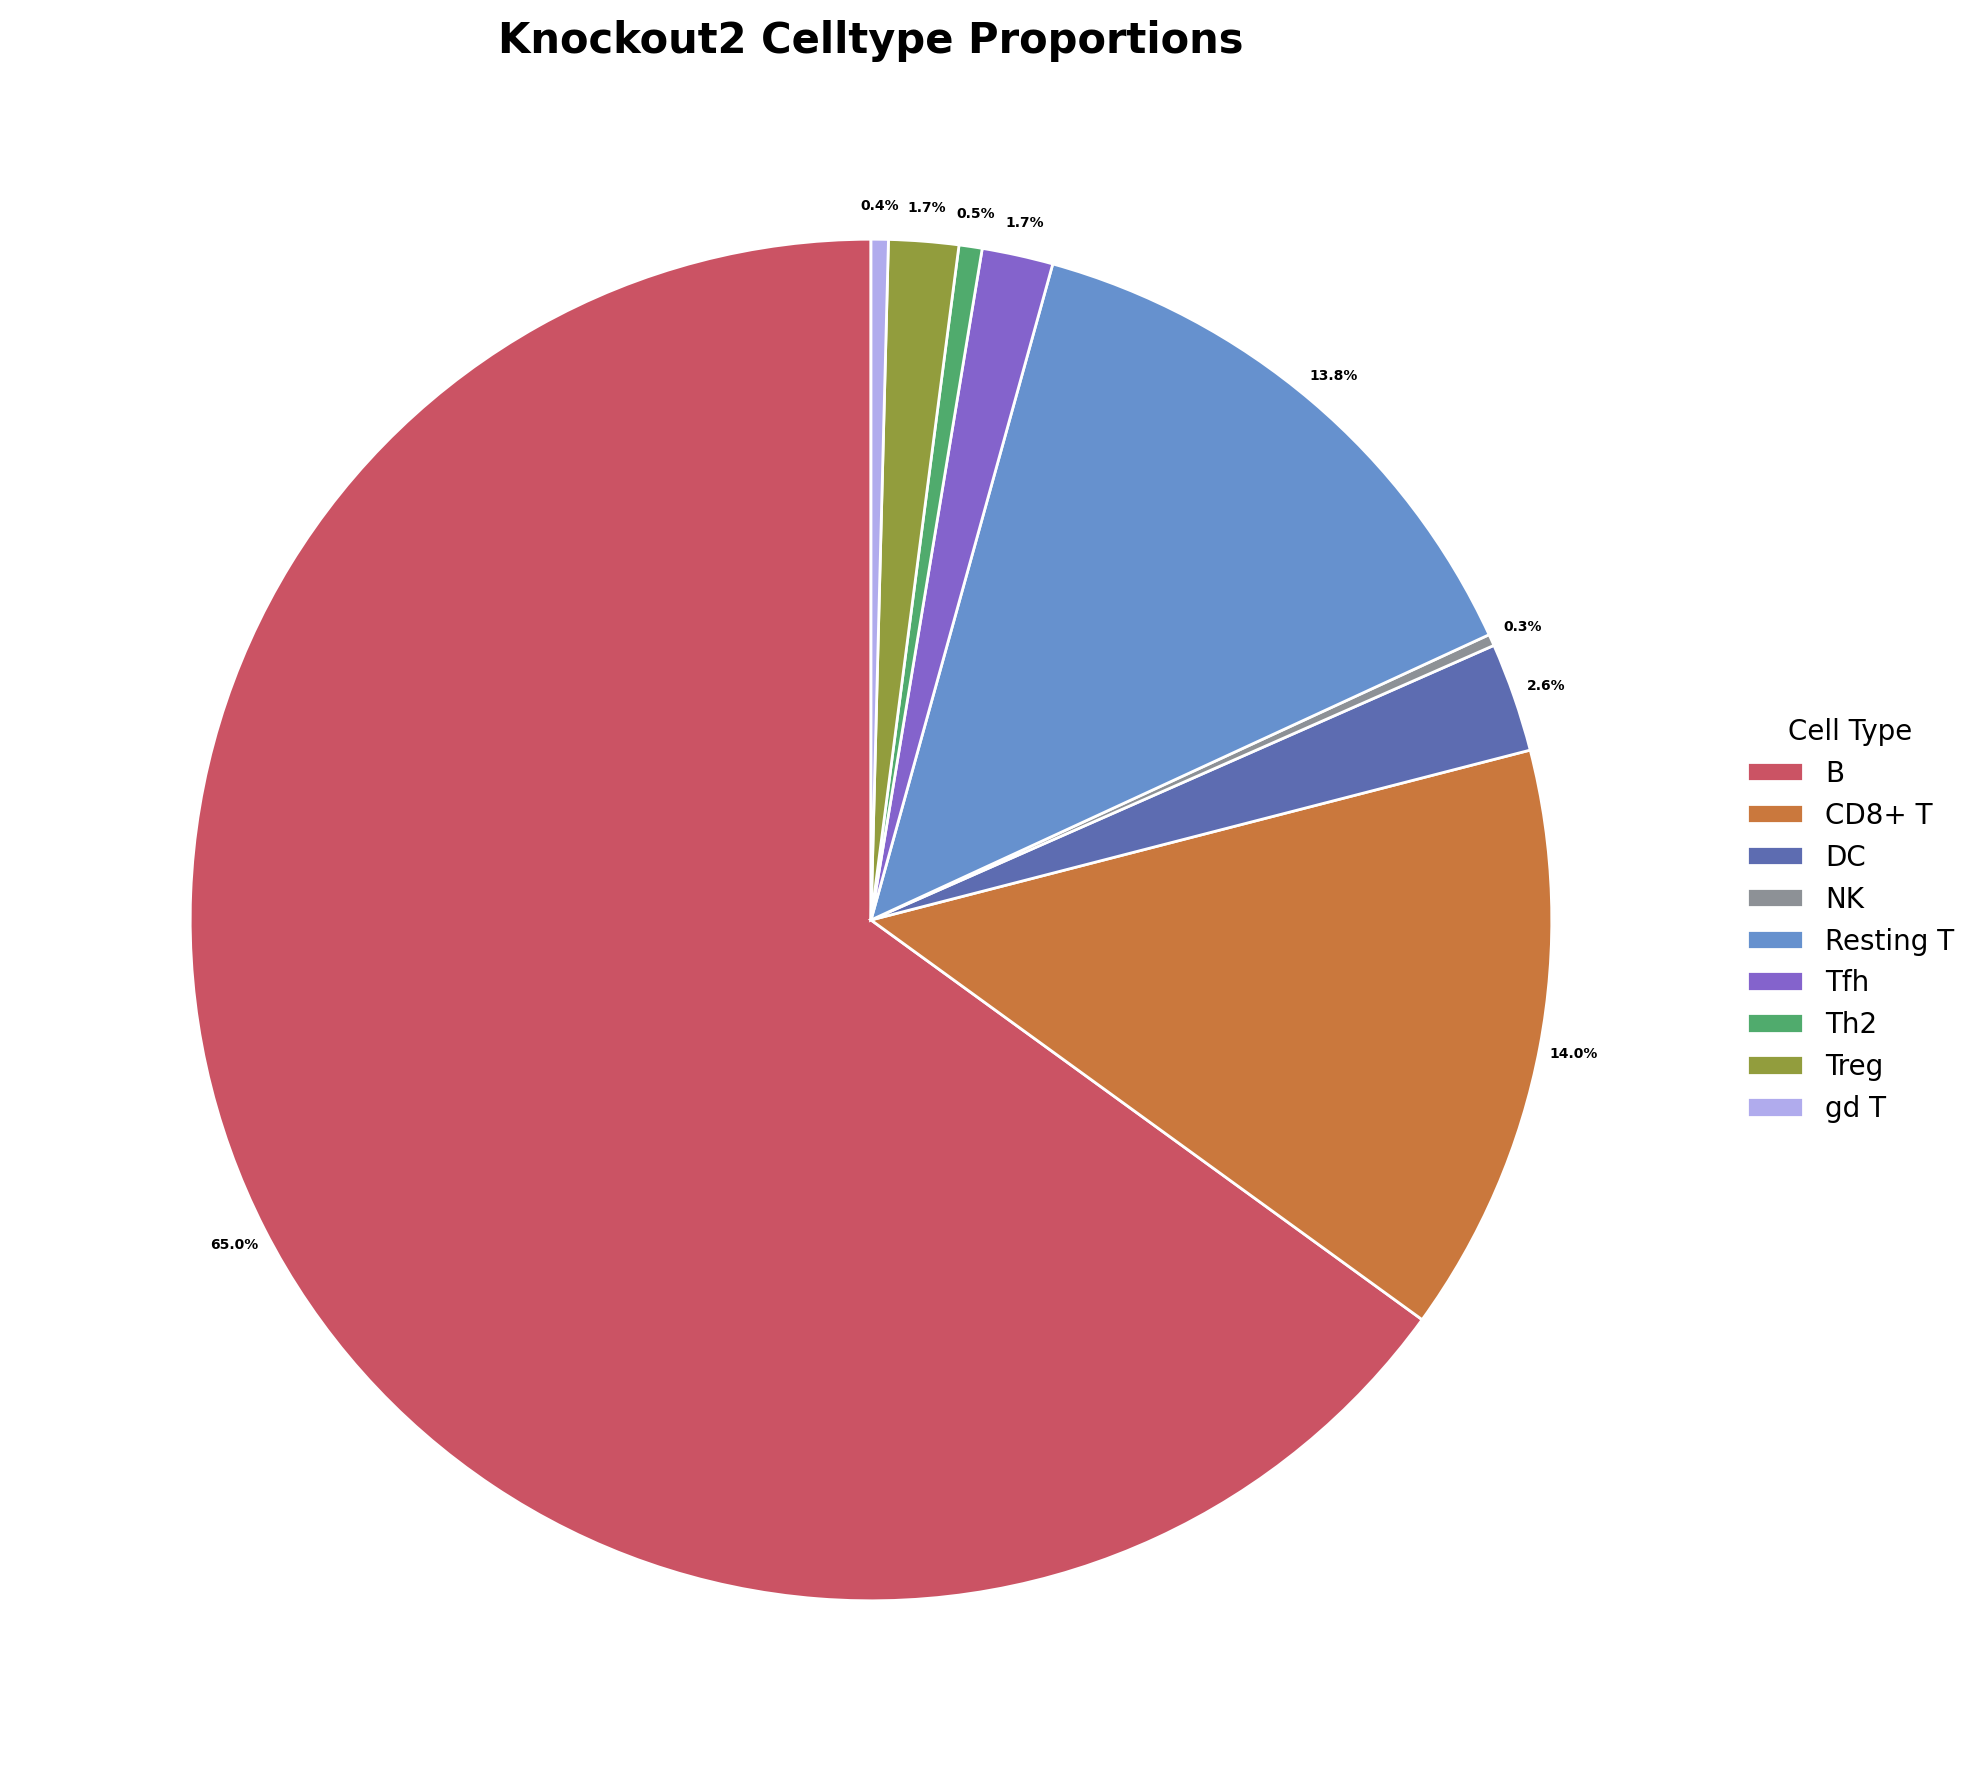

In [16]:
plot_celltype_pie(control_props, 'Control Cell Type Proportions', 'celltype_pie_control')
plot_celltype_pie(ko_props, 'Knockout1 Cell Type Proportions', 'celltype_pie_knockout')
plot_celltype_pie(ko2_props, 'Knockout2 Celltype Proportions', 'celltype_pie_knockout2')

In [66]:
# from spaceoracle.models.parallel_estimators import create_spatial_features

RADIUS = 200
workdir = '/ix3/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD'

spf_control = pd.read_csv(f'{workdir}/spf_control_{RADIUS}.csv', index_col=0)
spf_ko = pd.read_csv(f'{workdir}/spf_ko_{RADIUS}.csv', index_col=0)
spf_ko2 = pd.read_csv(f'{workdir}/spf_ko2_{RADIUS}.csv', index_col=0)

spf_control.index = spf_control.index.astype(str)
spf_ko.index = spf_ko.index.astype(str)
spf_ko2.index = spf_ko2.index.astype(str)

In [67]:
def normalize_rows(df, adata):
    df = df.copy()
    cell_counts = adata.obs.cell_type.value_counts()
    cell_counts.rename(index=lambda x: x+'_within', inplace=True)
    
    df = df / cell_counts

    # normalize each row to sum to 1 (percentage of ct_within)
    row_sums = df.sum(axis=1)
    df = df.div(row_sums, axis=0)

    return df 


In [68]:
%%time 

spf_control = normalize_rows(spf_control, adata_control)
spf_ko = normalize_rows(spf_ko, adata_ko)
spf_ko2 = normalize_rows(spf_ko2, adata_ko2)

CPU times: user 52.6 ms, sys: 0 ns, total: 52.6 ms
Wall time: 133 ms


In [69]:
control_th2_1der = adata_control[adata_control.obs['cell_type'] == 'Th2']
control_th2_1der = control_th2_1der[control_th2_1der[:, 'Prdm1'].to_df(layer='raw_count').iloc[:, 0] > 0].obs.index

ko_th2_1der = adata_ko[adata_ko.obs['cell_type'] == 'Th2']
ko_th2_1der = ko_th2_1der[
      (ko_th2_1der[:, 'Prdm1'].to_df(layer='raw_count').iloc[:, 0] > 0)
    & (ko_th2_1der[:, 'Ccr4'].to_df(layer='raw_count').iloc[:, 0] < 1)].obs.index

ko2_th2_1der = adata_ko2[adata_ko2.obs['cell_type'] == 'Th2']
ko2_th2_1der = ko2_th2_1der[
      (ko2_th2_1der[:, 'Prdm1'].to_df(layer='raw_count').iloc[:, 0] > 0)
    & (ko2_th2_1der[:, 'Ccr4'].to_df(layer='raw_count').iloc[:, 0] < 1)].obs.index

len(control_th2_1der), len(ko_th2_1der), len(ko2_th2_1der)

(30, 17, 34)

B_within - Control vs KO: p = 0.0108
CD8+ T_within - Control vs KO: p = 0.1223


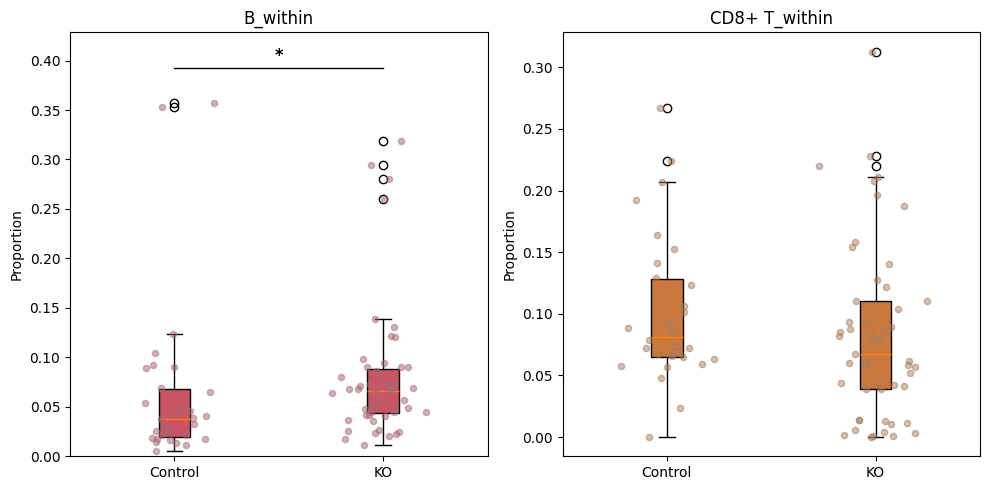

In [ ]:
from scipy import stats
control_data = spf_control.loc[control_th2_1der]
ko_data = pd.concat([spf_ko.loc[ko_th2_1der], spf_ko2.loc[ko2_th2_1der]])

all_keys = ['B_within', 'CD8+ T_within']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

p_values = {}
for i, key in enumerate(all_keys):
    control_values = control_data[key].dropna()
    ko_values = ko_data[key].dropna()
    
    data = [control_values, ko_values]
    bp = axes[i].boxplot(data, labels=['Control', 'KO'], patch_artist=True)
    
    # Color the boxes based on cell type
    cell_type = key.replace('_within', '')
    box_color = color_dict[cell_type]
    for patch in bp['boxes']:
        patch.set_facecolor(box_color)
    
    x_control = np.random.normal(1, 0.1, len(control_values))
    axes[i].scatter(x_control, control_values, alpha=0.5, s=20, color=box_color, zorder=10, edgecolor='gray')
    
    x_ko = np.random.normal(2, 0.1, len(ko_values))
    axes[i].scatter(x_ko, ko_values, alpha=0.5, s=20, color=box_color, zorder=10, edgecolor='gray')
    
    axes[i].set_title(key)
    axes[i].set_ylabel('Proportion')
    
    # Mann-Whitney U test
    _, p_value = stats.mannwhitneyu(control_values, ko_values, alternative='two-sided')
    p_values[key] = p_value
    
    print(f"{key} - Control vs KO: p = {p_value:.4f}")
    
    # Add significance annotation
    y_max = max([max(data) for data in data if len(data) > 0])
    if p_value < 0.05:
        y_pos = y_max + y_max*0.1
        axes[i].plot([1, 2], [y_pos, y_pos], 'k-', linewidth=1)
        axes[i].text(1.5, y_pos + y_max*0.02, '*', ha='center', fontsize=12, fontweight='bold')
        axes[i].set_ylim(0, y_max + y_max*0.2)

plt.tight_layout()
plt.savefig('figures/neighborhood_boxplots_B_CD8T.svg', dpi=300, format='svg', transparent=True, bbox_inches='tight')

In [71]:
print("\n=== Summary Statistics ===")
for key in all_keys:
    control_values = control_data[key].dropna()
    ko_values = ko_data[key].dropna()
    if len(control_values) > 0 and len(ko_values) > 0:
        print(f"Control - {key} mean: {control_values.mean():.4f}")
        print(f"KO - {key} mean: {ko_values.mean():.4f}")

print("\n=== Pairwise Comparisons (Mann-Whitney U) ===")
for key, p_value in p_values.items():
    print(f"{key} - Control vs KO: p = {p_value:.4f}")


=== Summary Statistics ===
Control - B_within mean: 0.0642
KO - B_within mean: 0.0798
Control - CD8+ T_within mean: 0.1011
KO - CD8+ T_within mean: 0.0834

=== Pairwise Comparisons (Mann-Whitney U) ===
B_within - Control vs KO: p = 0.0108
CD8+ T_within - Control vs KO: p = 0.1223


In [75]:
adata = adata_control

prdm1 = adata[:, ['Prdm1']].to_df(layer='raw_count')
prdm1 = prdm1[prdm1['Prdm1'] > 0].index

ct_transfer = '1der'

th2 = adata[((adata.obs['cell_type'] == 'Th2')), :].obs.index
tfh = adata[((adata.obs['cell_type'] == 'Tfh')), :].obs.index
treg = adata[((adata.obs['cell_type'] == 'Treg')), :].obs.index

transferred = (set(tfh) | set(th2) | set(treg)) & set(prdm1)
transferred = list(transferred)

len(transferred)

107

In [86]:
ko_transferred = adata_ko[:, ['Prdm1', 'Ccr4']].to_df(layer='raw_count')
ko_transferred = ko_transferred[((ko_transferred['Prdm1'] > 0) & (ko_transferred['Ccr4'] < 1))].index

ko_transferred = adata_ko[
        (adata_ko.obs.index.isin(ko_transferred)) 
        & ((adata_ko.obs.cell_type == 'Th2') | (adata_ko.obs.cell_type == 'Tfh') | (adata_ko.obs.cell_type == 'Treg'))
        # & (ko_adata.obs.cell_type == 'Th2')
        # & (ko_adata.obs.cell_type == 'Tfh')
    ].obs_names

ko_transferred = list(ko_transferred)
len(ko_transferred)

60

In [103]:
adata.obs['sample'] = 'lymph1'
adata_ko.obs['sample'] = 'lymphKO4'

combined_adata = sc.concat([adata[transferred, :], adata_ko[ko_transferred, :]])
combined_adata.X = combined_adata.layers['corrected_count']
sc.pp.log1p(combined_adata)

sc.tl.rank_genes_groups(combined_adata, 'sample', method='wilcoxon', use_raw=False)
degs_df = sc.get.rank_genes_groups_df(combined_adata, group='lymphKO4', key='rank_genes_groups')

top_degs_df = degs_df.sort_values('scores', key=abs, ascending=False)

In [104]:
goi = 'Ccr4'

simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_1der.parquet')
    for part in ['a', 'b', 'c', 'd']]
simulated_gex = pd.concat(simulated_gex, axis=0)

In [105]:
gex_control = adata[transferred, :].to_df(layer='corrected_count').copy()
gex_ko = adata_ko[ko_transferred, :].to_df(layer='corrected_count').copy()\

delta_sim = simulated_gex.loc[transferred, :] - adata[transferred, :].to_df(layer='imputed_count')
gex_sim = gex_control + delta_sim 
gex_sim = simulated_gex.loc[transferred, :]


In [107]:
def plot_corr(gex_control, gex_sim, gex_ko, top_genes, n_genes, corr_type='pearson'):

    changed_genes = top_degs_df.head(n_genes)['names'].values

    if 'Ccr4' in changed_genes:
        changed_genes = changed_genes[changed_genes != 'Ccr4']

    gex_control = gex_control[changed_genes].mean(axis=0)
    gex_sim = gex_sim[changed_genes].mean(axis=0)
    gex_ko = gex_ko[changed_genes].mean(axis=0)

    if corr_type == 'pearson':
        corr = pearsonr(gex_ko, gex_sim).statistic
        corr_control = pearsonr(gex_ko, gex_control).statistic
    elif corr_type == 'spearman':
        corr = spearmanr(gex_ko, gex_sim).statistic
        corr_control = spearmanr(gex_ko, gex_control).statistic
    
    correlations = {'SpaceTravLR': corr, 'Unperturbed': corr_control}

    plt.bar(correlations.keys(), correlations.values(), linewidth=2, 
        edgecolor='black', color=['salmon', 'deepskyblue', 'grey'])

    plt.ylabel('Pearson Correlation Coefficient')
    plt.title(r'experimental vs $\it{in\ silico}$ predictions' + f'\nfor top ' + str(n_genes) + ' genes')

    for i, (key, value) in enumerate(correlations.items()):
        plt.text(i, max(value, 0) - 0.1, f'{value:.2f}', ha='center', 
            va='center', color='black', fontweight='bold')
        
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.savefig(f'figures/{corr_type}_1der_{n_genes}.svg', transparent=True, bbox_inches='tight', dpi=300, format='svg')
    plt.show()


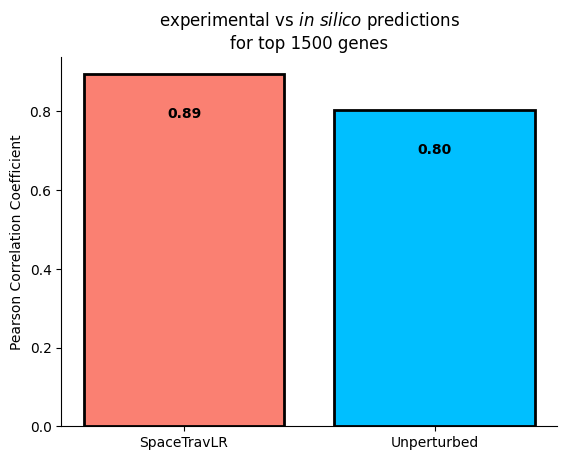

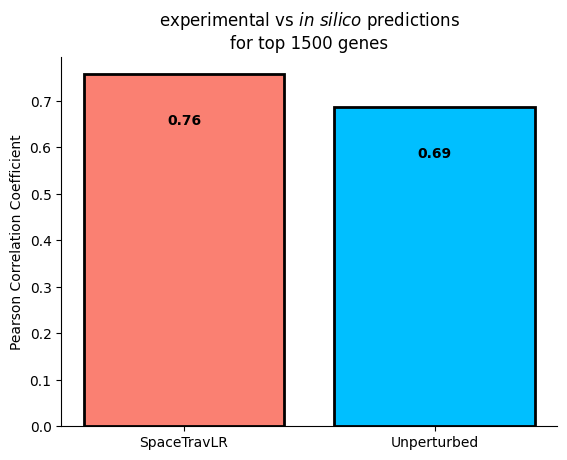

In [108]:
plot_corr(gex_control, gex_sim, gex_ko, top_degs_df, n_genes=1500, corr_type='pearson')
plot_corr(gex_control, gex_sim, gex_ko, top_degs_df, n_genes=1500, corr_type='spearman')

In [135]:
b_counts = adata.obs['banksy_cluster'].value_counts()
adata.obs['banksy_cluster'] = [x if b_counts[x] > 100 else 'other' for x in adata.obs['banksy_cluster']]
adata.obs['banksy_cluster'] = adata.obs['banksy_cluster'].astype('str')

adata.obs['banksy_cluster'].value_counts()

banksy_cluster
0        25068
1        14905
3        14870
4        11055
5        10693
7         7053
9         5119
other      533
Name: count, dtype: int64

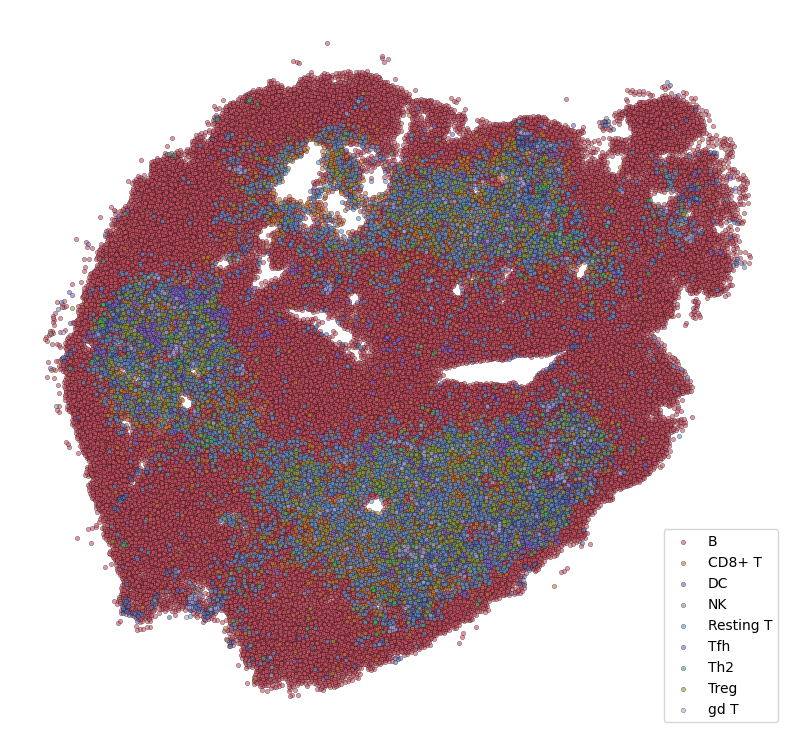

In [156]:
fig, ax = plt.subplots(figsize=(10, 10))

for ct in sorted(adata.obs['cell_type'].unique()):
    ax.scatter(adata[adata.obs['cell_type'] == ct].obsm['spatial'][:, 0], adata[adata.obs['cell_type'] == ct].obsm['spatial'][:, 1], 
               c=color_dict[ct], label=ct, s=10, edgecolor='black', linewidth=0.3, alpha=0.6)

ax.set_aspect('equal')
ax.set_axis_off()
ax.legend()
plt.savefig('figures/celltypes_spatial.svg', transparent=True, bbox_inches='tight', dpi=300, format='svg')
plt.show()

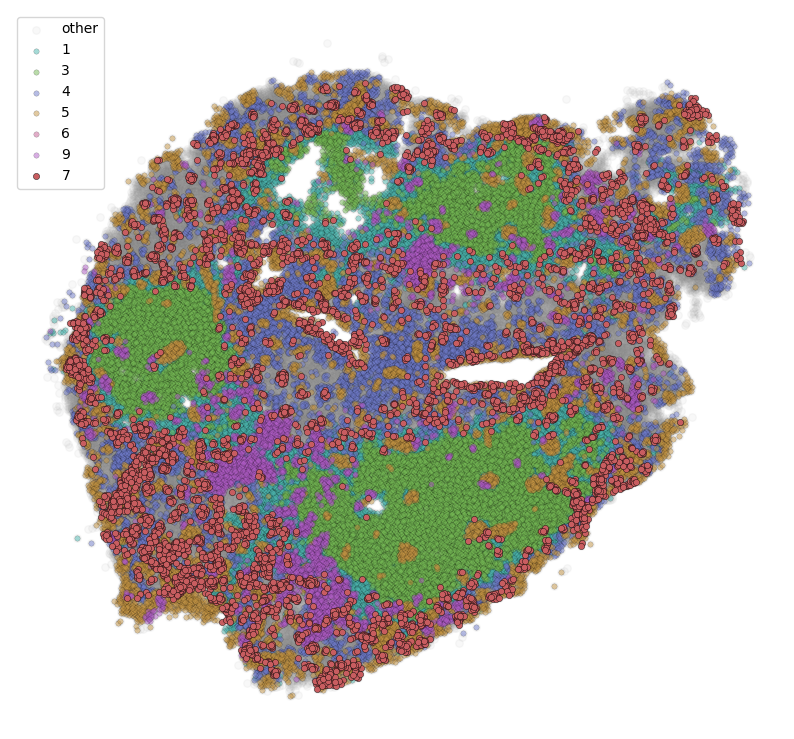

In [157]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
           c='gray', label='other', s=20, alpha=0.05)

for bclust in [1, 3, 4, 5, 6, 9]:
    bclust = str(bclust)
    adata_bclust = adata[adata.obs['banksy_cluster'] == str(bclust), :]
    ax.scatter(adata_bclust.obsm['spatial'][:, 0], adata_bclust.obsm['spatial'][:, 1], 
               c=color_dict[bclust], label=bclust, s=15, edgecolor='black', linewidth=0.2, alpha=0.5)

ax.scatter(
    adata[adata.obs['banksy_cluster'] == '7'].obsm['spatial'][:, 0], 
    adata[adata.obs['banksy_cluster'] == '7'].obsm['spatial'][:, 1], 
    c=color_dict['7'], label='7', s=20, edgecolor='black', linewidth=0.3)

ax.set_aspect('equal')
ax.set_axis_off()
ax.legend()
plt.savefig('figures/banksy_clusters.svg', transparent=True, bbox_inches='tight', dpi=300, format='svg')
plt.show()

In [140]:
adata_ = adata[adata.obs.cell_type == 'Th2']
chart = Cartography(adata_, color_dict)

In [141]:
simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/Ccr4_4n_0x_Th2.parquet')
    for part in ['a', 'b', 'c', 'd']]

simulated_gex = pd.concat(simulated_gex, axis=0)
simulated_gex.shape

# SpaceTravLR
simulated_df = simulated_gex.loc[chart.adata.obs.index]
simulated_df

,Adam11,Adam12,Adam23,Adam8,Adamts10,Adap1,Adcy6,Adgre4,Adgre5,Adgrg6,...,Zkscan6,Zmat3,Zmat5,Zmym1,Zmynd11,Zmynd12,Zmynd15,Znfx1,Znhit2,Zup1
object_id,,,,,,,,,,,,,,,,,,,,,
205621,0.033682,0.015682,0.029757,0.041193,0.082051,0.134311,0.010419,0.001958,0.085663,0.005500,...,0.042307,0.003097,0.034391,0.008057,0.140079,0.0,0.027054,0.016620,0.019204,0.038001
198055,0.026961,0.021694,0.020283,0.048693,0.072981,0.153612,0.016732,0.001349,0.098725,0.005645,...,0.038833,0.002859,0.036635,0.015029,0.148809,0.0,0.028245,0.022923,0.022275,0.035578
172832,0.028045,0.013899,0.015317,0.039197,0.057006,0.142313,0.013736,0.001108,0.093021,0.003542,...,0.046548,0.024518,0.040228,0.013755,0.150766,0.0,0.019443,0.015483,0.019374,0.034110
219678,0.029573,0.020801,0.015212,0.053130,0.068970,0.188177,0.013654,0.001271,0.095100,0.007335,...,0.043265,0.003107,0.039705,0.010922,0.149622,0.0,0.023774,0.021136,0.021940,0.038381
259850,0.034733,0.016717,0.013821,0.048098,0.066021,0.144789,0.011881,0.002629,0.088401,0.007020,...,0.038880,0.003287,0.034604,0.009055,0.129367,0.0,0.021865,0.019314,0.022795,0.035802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247282,0.029380,0.026949,0.014757,0.055184,0.072135,0.164600,0.020399,0.001214,0.105580,0.008541,...,0.032537,0.001819,0.038699,0.021781,0.130764,0.0,0.025243,0.025085,0.022063,0.058249
211705,0.028997,0.025972,0.013775,0.050454,0.061870,0.142553,0.011451,0.002039,0.084198,0.007371,...,0.042249,0.001886,0.031184,0.008633,0.169024,0.0,0.027635,0.026561,0.022492,0.039108
197779,0.026677,0.029701,0.013621,0.046670,0.081778,0.169157,0.024149,0.001038,0.105730,0.006581,...,0.035726,0.001862,0.044799,0.012931,0.143846,0.0,0.026669,0.039211,0.021893,0.037606


In [142]:
delta_X = (simulated_df - chart.unperturbed_expression).values
gene_mtx = chart.unperturbed_expression.values
P = chart.compute_transition_probabilities(
    delta_X, 
    embedding=chart.adata.obsm['X_umap'],
    n_neighbors=800)

In [143]:
chart.get_transition_annot(
    P,
    allowed_fates=chart.adata.obs['banksy_cluster'].unique(), 
    thresh=0, 
    annot='banksy_cluster'
)

100%|██████████| 134/134 [00:12<00:00, 10.96it/s]


source ct 1 Counter({'7': 132, '5': 1, '1': 1}) 0.0023679078699211913 0.0009920380401738287


100%|██████████| 202/202 [00:26<00:00,  7.51it/s]


source ct 3 Counter({'7': 185, '3': 7, '5': 7, '1': 3}) 0.002365598374203532 0.0003457808111326061


100%|██████████| 35/35 [00:04<00:00,  7.48it/s]


source ct 9 Counter({'7': 35}) 0.0023365421181009453 0.0011992021468167026


100%|██████████| 22/22 [00:03<00:00,  6.59it/s]


source ct 4 Counter({'7': 21, '4': 1}) 0.0023570107276942366 0.0007430012485829865


100%|██████████| 38/38 [00:04<00:00,  9.28it/s]


source ct 5 Counter({'7': 38}) 0.0023304333032038876 0.0017311889658953525


100%|██████████| 2/2 [00:00<00:00, 12.33it/s]


source ct 7 Counter({'5': 2}) 0.0021852309672195642 0.0011687761659360401


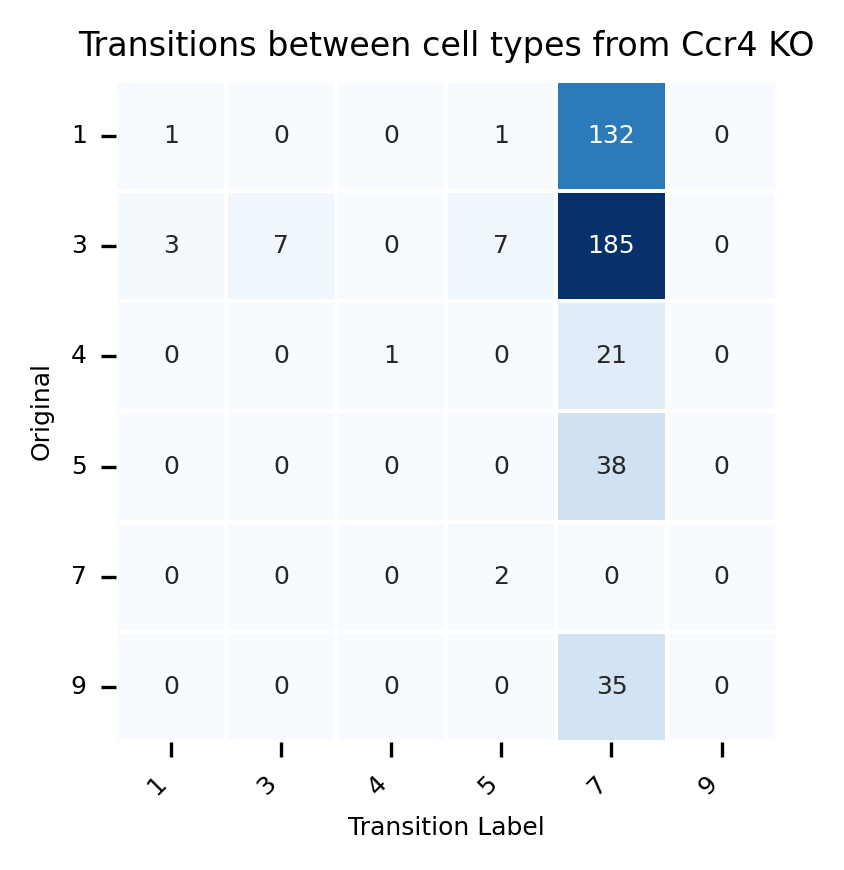

In [148]:
chart.adata.obs['banksy_cluster'] = chart.adata.obs['banksy_cluster'].astype('category')
chart.adata.obs['banksy_cluster'] = chart.adata.obs['banksy_cluster'].cat.remove_unused_categories()
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition']=chart.adata.obs['transition'].cat.remove_unused_categories()

df = chart.adata.obs[['banksy_cluster', 'transition']].copy()
counts = df.groupby(['banksy_cluster', 'transition']).size().unstack(fill_value=0)

if counts.empty:
    # Create empty DataFrame with same index and columns
    counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
elif len(counts.index) != len(counts.columns):
    # Add missing rows/columns with zeros
    all_labels = sorted(set(counts.index) | set(counts.columns))
    counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

plt.figure(figsize=(3,3), dpi=300)
sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # Changed to integer format
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title(f"Transitions between cell types from {goi} KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
plt.savefig(f'figures/mouse_lymph1_{goi}KO_transitions_Th2.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [149]:
import random
from spaceoracle.virtual_tissue import SubsampledTissue

lymph = SubsampledTissue(
    adata = adata,
    annot = 'cell_type',
    betadatas_paths = None,
    ko_paths = [
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1a_visiumHD',
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1b_visiumHD',
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1c_visiumHD',
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1d_visiumHD',
    ],
    suffix = '',
    n_props=4
)

In [150]:
genes=[
        ['Gata3', 'Pax5', 'Bcl6', 'Prdm1', 'Foxp3', 'Stat4'], 
        ['Il2ra', 'Ccr4', 'Il6st', 'Cxcr4', 'Il4ra', 'Cxcr5'],
        ['Il2', 'Il4', 'Ccl5', 'Il15', 'Cxcl13', 'Lgals9']
]

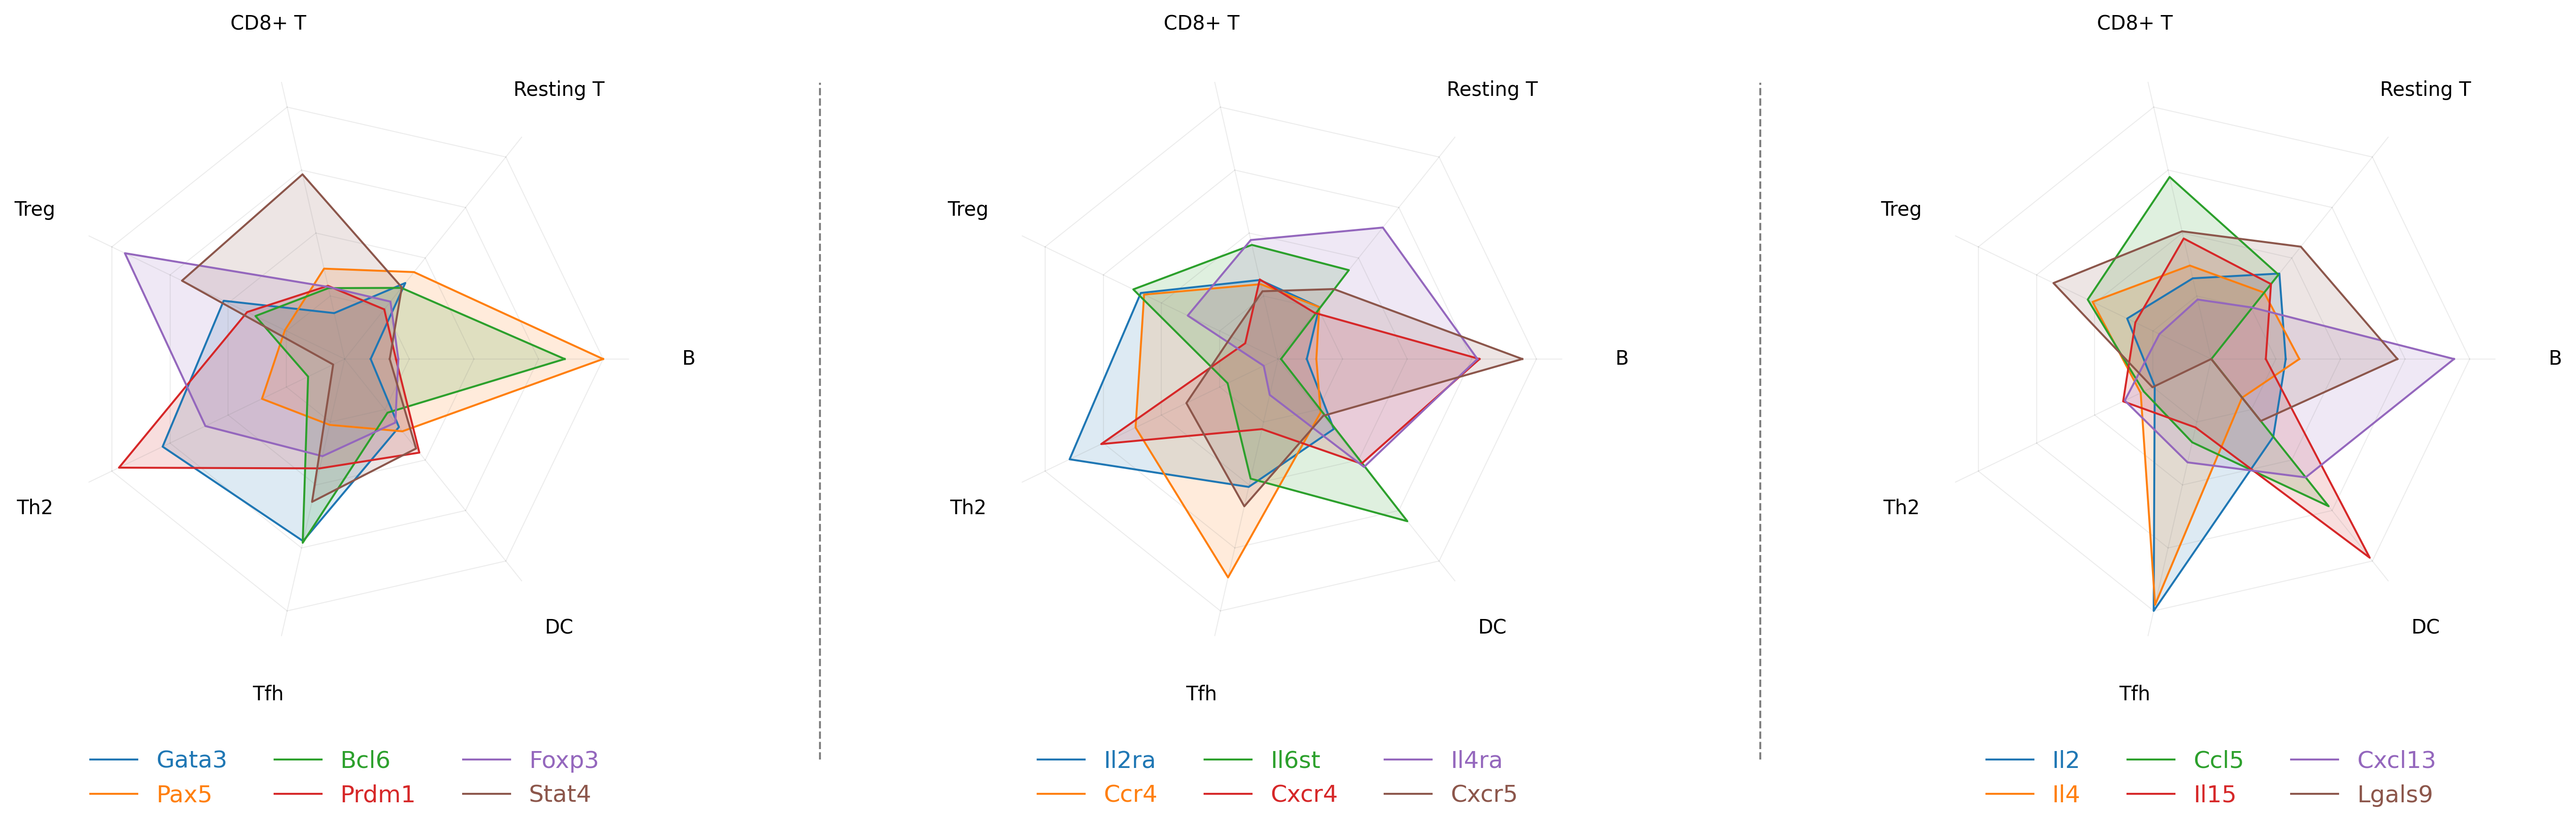

In [151]:
lymph.compute_ko_impact(genes=genes, cache_path='', force_recompute=True)

lymph.plot_radar(genes=genes, 
    show_for=['B', 'Resting T', 'CD8+ T', 'Treg', 'Th2', 'Tfh', 'DC'])

plt.savefig('figures/mouse_lymph_visiumHD_radar.svg', dpi=300, bbox_inches='tight', transparent=True, format='svg')